# Yandex.Afisha Project

By Valeriya Vazhnova

## Introduction

In order to assess the general situation of **Yandex.Afisha** service and sucess of its advertising campaign, we've recieved three datasets, containing information on website visits, orders and marketing expenses.

This information will help us learn more about Yandex.Afisha's customers and their behavior, as well as examine the service's marketing strategies and see if its expences can be optimised.

In our research, we are going to calculate several well-known business metrics, including daily, weekly and monthly number of active users, retention rate, customer acqusition cost and lifetime value and many more. All the received information will be analysed from two main points of view:

- by cohort (we are going to group the customers by month of their first visit);
- by advertising source.

## <a id='cont'>Contents</a>

**Part 1.** [Preprocessing the Data](#part1)

*Downloading and Exploring the Datasets*

- [Server Logs](#part1logs)
- [Orders](#part1orders)
- [Marketing Expenses](#part1expenses)

[*Conclusions to Part 1*](#part1concl)

**Part 2.** [Exploring the Data](#part2)

*Calculating Business Metrics*

- [Product](#part2product)
    - [Number of users per day / per week / per month](#part2number)
    - [Number of sessions per day](#part2sessions)
    - [Typical session length](#part2length)
    - [Retention rate](#part2retention)
- [Sales](#part2sales)
    - [Conversion time](#part2conversion)
    - [Number of orders](#part2orders)
    - [Average purchase size](#part2avgsize)
    - [Customers' lifetime value](#part2ltv)
- [Marketing Expenses](#part2marketing)
    - [Cost of advertising](#part2advcost)
    - [Customer acqusition cost](#part2cac)
    - [Return on marketing investments](#part2romi)

[*Conclusions to Part 2*](#part2concl)

[**General Conclusions**](#genconcl)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Well introduced project is half a job. It is an industrial standard and just a good style to give a short description about the project, its tasks and action plan we are going to take. Good start 👍👍👍
</div>
</font>

## <a id='part1'>Part 1. Preprocessing the Data</a>

First, we are going to download three datasets and do the exploratory data analysis. Since we don't know their size yet, we'll download small chunks of the data and try to establish the right parameters which will help us optimize memory usage. In our work, we are going to need several libraries: **pandas** for working with DataFrame objects, **numpy** can be useful in some calculations, **matplotlib** and **plotly.express** will help us visualize the data, while **seaborn** will be used for creating a heatmap. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
And it is great practice to comment every step you taken.
</div>
</font>

[Back to Contents](#cont)

### <a id='part1logs'>Server Logs</a>

In [2]:
try:
    logs = pd.read_csv('/Users/lera/Documents/Personal/_Yandex practicum/4_studies/sprint 7_business analytics/project/visits_log_us.csv')
except:
    logs = pd.read_csv('/datasets/visits_log_us.csv')

In [3]:
logs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 79.3 MB


We have a table with 359,400 rows in total. It uses 79.3MB. Let's start by downloading a small fraction of it and see what we can optimize. 

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
However in this case 79 Mb is not big amount of memory to pay extra work studying part of data, I agree that the approach is well for the future when we faced 790 or 7900 Mbs.
</div>
</font>

In [4]:
try:
    logs_500 = pd.read_csv('/Users/lera/Documents/Personal/_Yandex practicum/4_studies/sprint 7_business analytics/project/visits_log_us.csv', nrows=500)
except:
    logs_500 = pd.read_csv('/datasets/visits_log_us.csv', nrows=500)
logs_500.head()

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [5]:
logs_500.columns = logs.columns.str.lower()
logs_500.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   device     500 non-null    object
 1   end ts     500 non-null    object
 2   source id  500 non-null    int64 
 3   start ts   500 non-null    object
 4   uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 113.1 KB


In [6]:
logs_500['device'].value_counts()

desktop    363
touch      137
Name: device, dtype: int64

In [7]:
logs_500['source id'].describe()

count    500.000000
mean       3.892000
std        1.927633
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       10.000000
Name: source id, dtype: float64

This table has no missing values, but several columns don't have the right type of content: columns 'End Ts' and 'Start Ts' contain objects (strings) instead of timestamps. Also, contents of 'Device' column contains only two types of entries, so it should be converted to 'category'. Thus we'll be able to optimize memory usage.

Let's reload the data with the right parameters.

In [8]:
try:
    logs = pd.read_csv('/Users/lera/Documents/Personal/_Yandex practicum/4_studies/sprint 7_business analytics/project/visits_log_us.csv',
                    dtype={'Device':'category'},
                     parse_dates=['End Ts', 'Start Ts'])
except:
    logs = pd.read_csv('/datasets/visits_log_us.csv',
                       dtype={'Device':'category'},
                     parse_dates=['End Ts', 'Start Ts'])
logs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


Now the DataFrame uses only 11.3 MB, and all the columns have correct types of content. But we'd prefer to rename the columns in a uniform manner. We'll also check the dataset for missing values and duplicates.

In [9]:
logs.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
logs.isnull().sum()

device       0
end_ts       0
source_id    0
start_ts     0
uid          0
dtype: int64

In [10]:
logs.duplicated().sum()

0

In [11]:
logs.describe(include=['datetime', 'category'])

device               end_ts             start_ts
count    359400               359400               359400
unique        2               224760               224303
top     desktop  2017-11-24 16:51:00  2017-11-24 16:06:00
freq     262567                   23                   19
first       NaN  2017-06-01 00:02:00  2017-06-01 00:01:00
last        NaN  2018-06-01 01:26:00  2018-05-31 23:59:00

We've confirmed two facts:

1. The 'Device' column has two categories: desktop and touchscreen.
2. The timeframe of our data is from the 1st of June 2017 to the 1st of June 2018, i.e. a full year.

In [12]:
logs.source_id.value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: source_id, dtype: int64

Our users come from different ad sources, of which we only know their digital codes. From the numbering we can assume that there are 10 unique sources, but only 9 of them appear in this table. Aparrently, the source #8 didn't attract any visitors.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Well loaded and prepared dataframe, great.
</div>
</font>

### <a id='part1orders'>Orders</a>

With the next dataset, containing data on orders, we are going to deal in a similar way.

In [13]:
try:
    orders_500 = pd.read_csv('/Users/lera/Documents/Personal/_Yandex practicum/4_studies/sprint 7_business analytics/project/orders_log_us.csv', nrows=500)
except:
    orders_500 = pd.read_csv('/datasets/orders_log_us.csv', nrows=500)
orders_500.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   500 non-null    object 
 1   Revenue  500 non-null    float64
 2   Uid      500 non-null    uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 45.0 KB


In [14]:
orders_500.head()

Buy Ts  Revenue                   Uid
0  2017-06-01 00:10:00    17.00  10329302124590727494
1  2017-06-01 00:25:00     0.55  11627257723692907447
2  2017-06-01 00:27:00     0.37  17903680561304213844
3  2017-06-01 00:29:00     0.55  16109239769442553005
4  2017-06-01 07:58:00     0.37  14200605875248379450

We'll convert the column 'Buy Ts' to datetime format, the rest of the table seems to be in order.

In [15]:
try:
    orders = pd.read_csv('/Users/lera/Documents/Personal/_Yandex practicum/4_studies/sprint 7_business analytics/project/orders_log_us.csv',
                    parse_dates=['Buy Ts'])
except:
    orders = pd.read_csv('/datasets/orders_log_us.csv', 
                        parse_dates=['Buy Ts'])
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


We'll rename the column names, check the dataset for duplicates and misisng values.

In [16]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [17]:
orders.isnull().sum()

buy_ts     0
revenue    0
uid        0
dtype: int64

In [18]:
orders.duplicated().sum()

0

In [19]:
orders['revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

In [20]:
print('{:} entries ({:.2%} of all orders) have zero revenue!'.format(len(orders.query('revenue == 0')), len(orders.query('revenue == 0')) / len(orders)))

51 entries (0.10% of all orders) have zero revenue!


These must be missing values: it doesn't make sense that the customers were ordering something that costs 0. Since there's less than 1% of such orders, we can just filter them out.

In [21]:
orders = orders.query('revenue != 0')
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50364 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50364 non-null  datetime64[ns]
 1   revenue  50364 non-null  float64       
 2   uid      50364 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.5 MB


In [22]:
orders.describe(include='datetime')

buy_ts
count                 50364
unique                45950
top     2018-05-31 10:13:00
freq                      9
first   2017-06-01 00:10:00
last    2018-06-01 00:02:00

Again, we've learned that we have data for the purchases between 1st of June 2017 and 1st of June 2018. This is exactly the same period as in the logs dataframe.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Well done 👍👍👍
</div>
</font>

### <a id='part1expenses'>Marketing Expenses</a>

We are going to deal with marketing expenses statistics in the same way as we did with the two previous datasets.

In [23]:
try:
    costs = pd.read_csv('/Users/lera/Documents/Personal/_Yandex practicum/4_studies/sprint 7_business analytics/project/costs_us.csv')
except:
    costs = pd.read_csv('/datasets/costs_us.csv')
costs.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 206.2 KB


In [24]:
costs.head()

source_id          dt  costs
0          1  2017-06-01  75.20
1          1  2017-06-02  62.25
2          1  2017-06-03  36.53
3          1  2017-06-04  55.00
4          1  2017-06-05  57.08

In this case, the dataset is rather small, no need to download a sample first. However, we'll still convert data to the right type (download the 'dt' column as a datetime object).

In [25]:
try:
    costs = pd.read_csv('/Users/lera/Documents/Personal/_Yandex practicum/4_studies/sprint 7_business analytics/project/costs_us.csv',
                   parse_dates=['dt'])
except:
    costs = pd.read_csv('/datasets/costs_us.csv',
                       parse_dates=['dt'])
costs.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In order to clarify the contents of the table, we are going to rename some of the columns. Then we are going to check the dataframe for missing values and duplicates.

In [26]:
costs.rename(columns={'dt':'advertising_ts', 'costs':'advertising_costs'}, inplace=True)
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   source_id          2542 non-null   int64         
 1   advertising_ts     2542 non-null   datetime64[ns]
 2   advertising_costs  2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [27]:
costs.isnull().sum()

source_id            0
advertising_ts       0
advertising_costs    0
dtype: int64

In [28]:
costs.duplicated().sum()

0

In [29]:
costs.describe()

source_id  advertising_costs
count  2542.000000        2542.000000
mean      4.857199         129.477427
std       3.181581         156.296628
min       1.000000           0.540000
25%       2.000000          21.945000
50%       4.000000          77.295000
75%       9.000000         170.065000
max      10.000000        1788.280000

In [30]:
costs.describe(include='datetime')

advertising_ts
count                  2542
unique                  364
top     2018-03-03 00:00:00
freq                      7
first   2017-06-01 00:00:00
last    2018-05-31 00:00:00

So, we have the data on marketing expenses between 1st of June 2017 and 31st of May 2018. That's virtually the dame period as in the previous two dataframes.

In [31]:
costs.source_id.value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

Here we want to point out one peculiar detail. Presumably there were 10 different types of advertising. We have documented expenses for the sources 1-5, 9 and 10. But as we remember from the logs dataframe, there also were users coming from sources 6 and 7. Does it mean that these sources were free? Also, it's worth noticing that we don't have a single user from the source #8.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
An interesting finding about advert sources.
</div>
</font>

### <a id='part1concl'>*Conclusions to Part 1*</a>

To begin with, we've downloaded all the data, converted it to the necessary types and explored it to some extent. This helped us notice an interesting fact: some of the ad sources seem to attract customers, but the expenses on them are either not documented or non-existent.

[Back to Contents](#cont)

## <a id='part2'> Part 2. Exploring the Data</a>

In this section, we are going to look deeper in the given data and calculate business metrics, which will help us draw conclusions on our customers' behavior.

These metrics will be devided in three main categories:

- exploring the way people interact with the service (**product**);
- describing **sales**;
- assessing **marketing expenses**.

[Back to Contents](#cont)

### <a id='part2product'>Product</a>

After learning about the customers' behavior, we are going to answer several questions:

1. How many people use Yandex.Afisha service every day, week, and month?
2. How many sessions are there typically per day?
3. What is the length of each session?
4. How often do users come back?

<a id='part2number'>**Number of users per day / per week / per month**</a>

In [32]:
logs.sample(10)

device              end_ts  source_id            start_ts  \
192452  desktop 2018-05-14 10:37:00          3 2018-05-14 10:36:00   
54551     touch 2017-07-29 01:09:00          3 2017-07-29 01:03:00   
19712     touch 2018-04-05 20:54:00          3 2018-04-05 20:30:00   
306133  desktop 2017-09-28 13:58:00          2 2017-09-28 13:55:00   
287776    touch 2018-04-18 22:00:00          1 2018-04-18 21:57:00   
75980     touch 2017-08-22 00:41:00          5 2017-08-22 00:40:00   
340810  desktop 2017-10-04 18:40:00          4 2017-10-04 18:13:00   
329369    touch 2018-01-06 02:18:00          4 2018-01-06 02:09:00   
127164  desktop 2017-10-11 00:02:00          4 2017-10-10 23:40:00   
90994     touch 2017-10-25 16:01:00          4 2017-10-25 15:55:00   

                         uid  
192452  13409807059537151077  
54551    9981203176791567456  
19712    5473716569242792709  
306133   8105869421445888141  
287776   7966354459791525733  
75980   12971640335966163515  
340810   4528340332563145066  
329369  15542009466900959783  
127164    389787501554807285  
90994   17558988785112914822

In [33]:
logs['month'] = logs['start_ts'].astype('datetime64[M]')
logs['week'] = logs['start_ts'].astype('datetime64[W]')
logs['date'] = logs['start_ts'].dt.date
logs.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid      month       week        date  
0  16879256277535980062 2017-12-01 2017-12-14  2017-12-20  
1    104060357244891740 2018-02-01 2018-02-15  2018-02-19  
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01  
3  16174680259334210214 2018-05-01 2018-05-17  2018-05-20  
4   9969694820036681168 2017-12-01 2017-12-21  2017-12-27

In [34]:
dau = logs.groupby('date').agg({'uid':'nunique'}).reset_index()
dau.columns = ['date', 'n_users']
dau.head()

date  n_users
0  2017-06-01      605
1  2017-06-02      608
2  2017-06-03      445
3  2017-06-04      476
4  2017-06-05      820

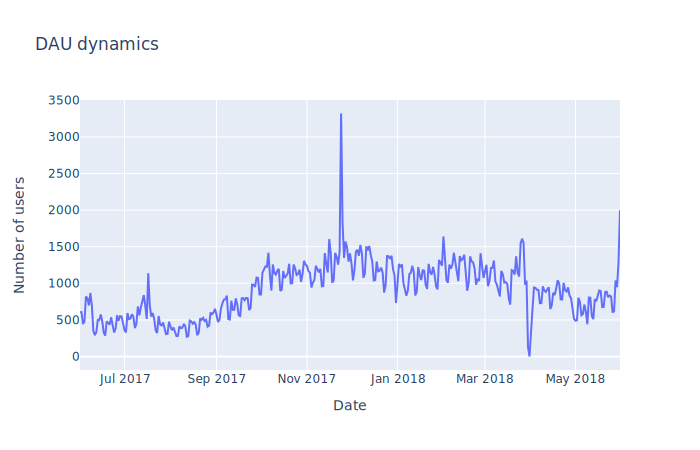

In [43]:
fig_dau = px.line(dau, x='date', y='n_users', title='DAU dynamics', labels=dict(date='Date', n_users='Number of users'))
fig_dau.show("svg")

This line graph shows us the dynamics of DAU (daily active users number). We can see a dramatic peak on November 24, 2017, which happens to be the day of Black Friday. There also was a significant drop between March 27 and April 5, reaching its lowest point on the 31st of March, 2018. We don't have enough information to explain this drop, it could be either due to some external factor or to malfunctioning of the service. The observed period ends with a visible rise of the number of daily visitors.

In [38]:
wau = logs.groupby('week').agg({'uid':'nunique'}).reset_index()
wau.columns = ['week', 'n_users']
wau.head()

week  n_users
0 2017-06-01     4082
1 2017-06-08     3311
2 2017-06-15     2844
3 2017-06-22     3079
4 2017-06-29     3055

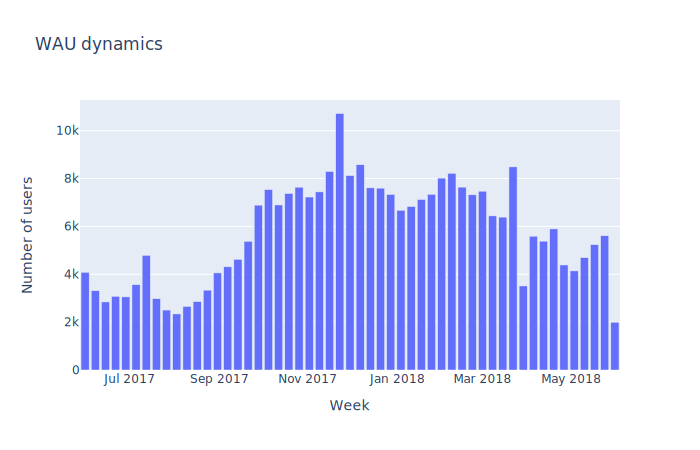

In [42]:
fig_wau = px.bar(wau, x='week', y='n_users', title='WAU dynamics',
                labels=dict(week='Week', n_users='Number of users'))
fig_wau.show('svg')

The number of weekly active users (WAU) has risen significantly between Septemper 2017 and May 2018. Two visible peaks are in November 2017 (Black Friday) and end of March 2018.

In [40]:
mau = logs.groupby(['month']).agg({'uid':'nunique'}).reset_index()
mau.columns = ['month', 'n_users']
mau

month  n_users
0  2017-06-01    13259
1  2017-07-01    14183
2  2017-08-01    11631
3  2017-09-01    18975
4  2017-10-01    29692
5  2017-11-01    32797
6  2017-12-01    31557
7  2018-01-01    28716
8  2018-02-01    28749
9  2018-03-01    27473
10 2018-04-01    21008
11 2018-05-01    20701

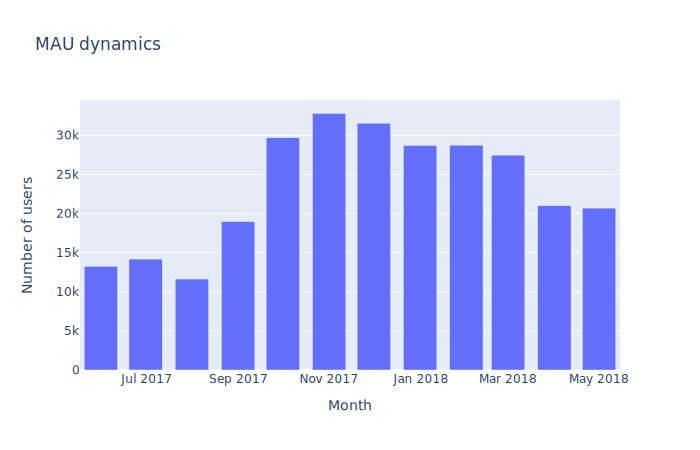

In [41]:
fig_mau = px.bar(mau, x='month', y='n_users', title='MAU dynamics',
                 labels=dict(month='Month', n_users='Number of users'))
fig_mau.show('svg')

This bar chart shows a significant growth of the total number of unique monthly users (MAU). From 13,000 users in June 2017 it reached 20,000 users in May 2018 with a peak of almost 33,000 users in November 2017 (again, this is the month of the Black Friday, which clealry affected our metrics.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Well calculated and visualized metrics, good job.
</div>
</font>

<a id='part2sessions'>**Number of sessions per day**</a>

In [44]:
spd = logs.groupby('date').agg({'uid':'count'}).reset_index()
spd.columns = ['date', 'total_sessions']
spd['dau'] = dau['n_users']
spd['sessions_per_user'] = spd['total_sessions'] / spd['dau']
spd.head()

date  total_sessions  dau  sessions_per_user
0  2017-06-01             664  605           1.097521
1  2017-06-02             658  608           1.082237
2  2017-06-03             477  445           1.071910
3  2017-06-04             510  476           1.071429
4  2017-06-05             893  820           1.089024

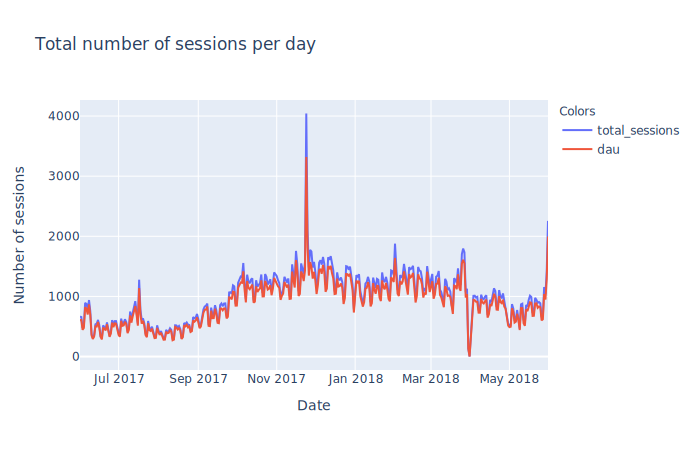

In [46]:
fig_spd = px.line(spd, x='date', y=['total_sessions', 'dau'],
                  title='Total number of sessions per day',
                 labels=dict(date='Date', value='Number of sessions', variable='Colors'))
fig_spd.show('svg')

The two lines on this graph (showing the total number of user sessions on Yandex.Afisha and the number of active daily users) are almost identical. We can assume, that most of the customers use the service only once during the day. 

In [47]:
spu = logs.groupby(['date', 'uid']).agg({'start_ts': 'count'}).reset_index()
spu.columns = ['date', 'uid', 'sessions']
spu.head()

date                 uid  sessions
0  2017-06-01   32197920403662046         1
1  2017-06-01  184148767273119549         2
2  2017-06-01  254239507810036143         1
3  2017-06-01  258099436367309303         1
4  2017-06-01  300776506671194537         1

In [48]:
spu['sessions'].value_counts()

1     307937
2      18323
3       2962
4        814
5        281
6        121
7         39
8         19
9         11
10         2
Name: sessions, dtype: int64

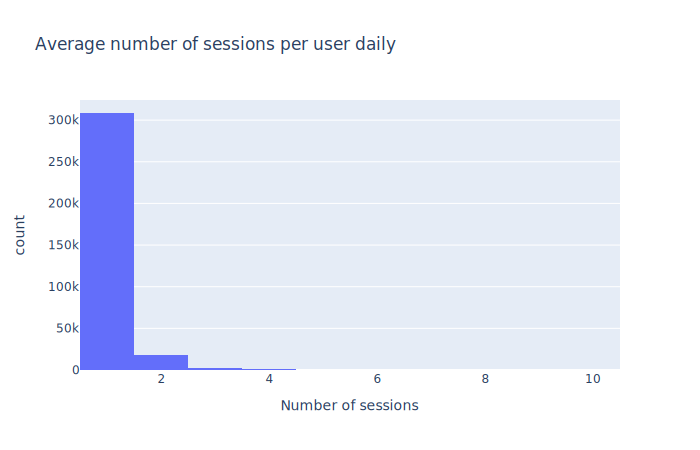

In [49]:
fig_spu = px.histogram(spu, x='sessions', title='Average number of sessions per user daily',
                      labels=dict(sessions='Number of sessions'))
fig_spu.show('svg')

Aparrently, the majority of the users have only one session per day. But there is a number of people who visit Yandex.Afisha two or three times a day, or sometimes even more (up to ten).

In [50]:
device = logs.groupby(['device', 'date']).agg({'uid':'count'}).reset_index()
device.columns = ['device', 'date', 'sessions_per_day']
device

device        date  sessions_per_day
0    desktop  2017-06-01               501
1    desktop  2017-06-02               498
2    desktop  2017-06-03               329
3    desktop  2017-06-04               349
4    desktop  2017-06-05               693
..       ...         ...               ...
723    touch  2018-05-27               246
724    touch  2018-05-28               321
725    touch  2018-05-29               284
726    touch  2018-05-30               421
727    touch  2018-05-31               712

[728 rows x 3 columns]

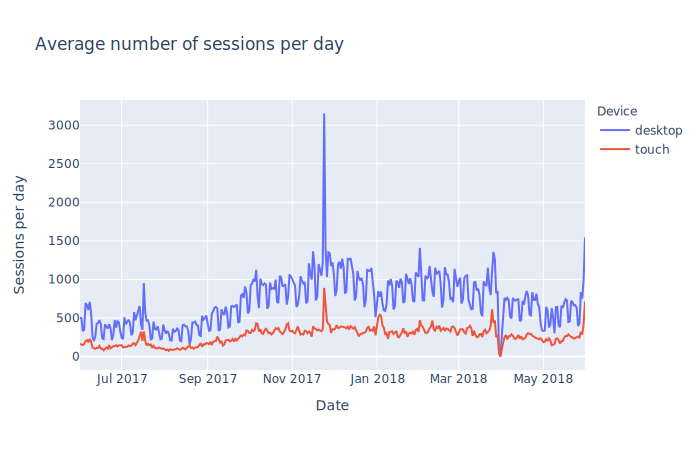

In [51]:
fig_device= px.line(device, x='date', y='sessions_per_day', color='device',
                    title = 'Average number of sessions per day',
                   labels=dict(date='Date', sessions_per_day='Sessions per day', device='Device'))
fig_device.show('svg')

Compared by the type of device they are using, the overwhelming majority of Yandex.Afisha customers prefers desktop computers to touchscreen devices. However, the general trends of the visits distribution remain similar for all kinds of customers.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
May be it is because it is so comfortable to study events and schedules on a big desktop screen. Good job.
</div>
</font>

<a id='part2length'>**Typical session length**</a>

In [52]:
logs['session_length'] = (logs['end_ts'] - logs['start_ts']).dt.seconds
logs.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid      month       week        date  session_length  
0  16879256277535980062 2017-12-01 2017-12-14  2017-12-20            1080  
1    104060357244891740 2018-02-01 2018-02-15  2018-02-19            1680  
2   7459035603376831527 2017-07-01 2017-06-29  2017-07-01               0  
3  16174680259334210214 2018-05-01 2018-05-17  2018-05-20            1440  
4   9969694820036681168 2017-12-01 2017-12-21  2017-12-27               0

In [53]:
logs.session_length.describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_length, dtype: float64

This parameter varies a lot: from 0 seconds to 84,480 seconds, or 58.6 days. The latter number seems highly implausible, perhaps it appeared in the given dataset due to some mistake in data collection, or it could describe a customer, who keeps Yandex.Afisha open in his browser all the time. This is why we are going to identify and remove the outliers.

First, we'll calculate interquartile range (IQR) for this data. Then, we are going to apply a simple rule: the majority of the data falls in the range between Q1-1.5IQR and Q3+1.5IQR. Everything outside of this range will be considered an outlier.

In [54]:
iqr = 840 - 120
upper_fence = iqr * 1.5 + 840
lower_fence = 120 - iqr * 1.5
print('Lower fence:', lower_fence)
print('Upper fence:', upper_fence)

Lower fence: -960.0
Upper fence: 1920.0


Since the length of the user session can't be negative, our minimal value is 0. We'll use only the upper fence value as a filter.

In [55]:
logs_filt = logs.query('session_length <= @upper_fence')

In [56]:
fig_asl = px.box(logs_filt, x='device', y='session_length',
                 title='Average session length compared by device',
                labels=dict(device='Device', session_length='Session length'))
fig_asl.show('svg')

In general, desktop sessions are a bit longer: usually they last between 120 and 720 seconds (2–12 minutes) with the median session length of 300 seconds (5 minutes). Touchscreen device sessions tend to last between 60 and 540 seconds (1–9 minutes) with the median length of 180 seconds (3 minutes).

[Back to Contents](#cont)

<font color='orange'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Well calculated and plotted block again.
</div>
<div class="alert alert-block alert-warning">
It would be great to plot a histogram, make a conclusion about distribution character and make a decision which metric to choose as the typical - mean, median or mode.
</div>
</font>

<a id='part2retention'>**Retention rate**</a>

In [57]:
first_session = logs.groupby('uid')['date'].min()
first_session.name='first_session'
logs = logs.join(first_session, on='uid')
logs

device              end_ts  source_id            start_ts  \
0         touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1       desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2         touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3       desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4       desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
...         ...                 ...        ...                 ...   
359395  desktop 2017-07-29 19:07:19          2 2017-07-29 19:07:00   
359396    touch 2018-01-25 17:38:19          1 2018-01-25 17:38:00   
359397  desktop 2018-03-03 10:12:19          4 2018-03-03 10:12:00   
359398  desktop 2017-11-02 10:12:19          5 2017-11-02 10:12:00   
359399    touch 2017-09-10 13:13:19          2 2017-09-10 13:13:00   

                         uid      month       week        date  \
0       16879256277535980062 2017-12-01 2017-12-14  2017-12-20   
1         104060357244891740 2018-02-01 2018-02-15  2018-02-19   
2        7459035603376831527 2017-07-01 2017-06-29  2017-07-01   
3       16174680259334210214 2018-05-01 2018-05-17  2018-05-20   
4        9969694820036681168 2017-12-01 2017-12-21  2017-12-27   
...                      ...        ...        ...         ...   
359395  18363291481961487539 2017-07-01 2017-07-27  2017-07-29   
359396  18370831553019119586 2018-01-01 2018-01-25  2018-01-25   
359397  18387297585500748294 2018-03-01 2018-03-01  2018-03-03   
359398  18388616944624776485 2017-11-01 2017-11-02  2017-11-02   
359399  18396128934054549559 2017-09-01 2017-09-07  2017-09-10   

        session_length first_session  
0                 1080    2017-12-20  
1                 1680    2018-02-19  
2                    0    2017-07-01  
3                 1440    2018-03-09  
4                    0    2017-12-27  
...                ...           ...  
359395              19    2017-07-29  
359396              19    2018-01-25  
359397              19    2018-03-03  
359398              19    2017-11-02  
359399              19    2017-09-10  

[359400 rows x 10 columns]

In [58]:
logs['lifetime'] = (logs['date'] - logs['first_session']) / np.timedelta64(1, 'M')
logs['cohort'] = logs['first_session'].astype('datetime64[M]')
logs['lifetime'] = logs['lifetime'].astype(int)
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   device          359400 non-null  category      
 1   end_ts          359400 non-null  datetime64[ns]
 2   source_id       359400 non-null  int64         
 3   start_ts        359400 non-null  datetime64[ns]
 4   uid             359400 non-null  uint64        
 5   month           359400 non-null  datetime64[ns]
 6   week            359400 non-null  datetime64[ns]
 7   date            359400 non-null  object        
 8   session_length  359400 non-null  int64         
 9   first_session   359400 non-null  object        
 10  lifetime        359400 non-null  int64         
 11  cohort          359400 non-null  datetime64[ns]
dtypes: category(1), datetime64[ns](5), int64(3), object(2), uint64(1)
memory usage: 30.5+ MB


In [59]:
cohorts = logs.groupby(['cohort', 'lifetime']).agg({'uid':'nunique'}).reset_index()
cohorts.columns = ['cohort', 'lifetime', 'n_users']
cohorts

cohort  lifetime  n_users
0  2017-06-01         0    13259
1  2017-06-01         1      778
2  2017-06-01         2      740
3  2017-06-01         3      890
4  2017-06-01         4      898
..        ...       ...      ...
73 2018-03-01         1      644
74 2018-03-01         2      302
75 2018-04-01         0    15709
76 2018-04-01         1      313
77 2018-05-01         0    15273

[78 rows x 3 columns]

In [60]:
initial_users = cohorts[cohorts['lifetime'] == 0][['cohort', 'n_users']]
initial_users.rename(columns={'n_users':'cohort_users'}, inplace=True)
cohorts = cohorts.merge(initial_users, on='cohort')
cohorts['retention'] = cohorts['n_users'] / cohorts['cohort_users']
cohorts

cohort  lifetime  n_users  cohort_users  retention
0  2017-06-01         0    13259         13259   1.000000
1  2017-06-01         1      778         13259   0.058677
2  2017-06-01         2      740         13259   0.055811
3  2017-06-01         3      890         13259   0.067124
4  2017-06-01         4      898         13259   0.067728
..        ...       ...      ...           ...        ...
73 2018-03-01         1      644         20589   0.031279
74 2018-03-01         2      302         20589   0.014668
75 2018-04-01         0    15709         15709   1.000000
76 2018-04-01         1      313         15709   0.019925
77 2018-05-01         0    15273         15273   1.000000

[78 rows x 5 columns]

In [61]:
retention = cohorts.pivot_table(index='cohort', columns='lifetime', values='retention', aggfunc='sum')
retention

lifetime     0         1         2         3         4         5         6   \
cohort                                                                        
2017-06-01  1.0  0.058677  0.055811  0.067124  0.067728  0.068406  0.059884   
2017-07-01  1.0  0.051294  0.056012  0.053501  0.056849  0.046271  0.047184   
2017-08-01  1.0  0.061487  0.060996  0.058049  0.044200  0.042039  0.040860   
2017-09-01  1.0  0.067708  0.063338  0.041367  0.039571  0.037416  0.028556   
2017-10-01  1.0  0.062671  0.043692  0.038342  0.034415  0.025061  0.020403   
2017-11-01  1.0  0.050829  0.041618  0.036296  0.027195  0.021506  0.010937   
2017-12-01  1.0  0.044404  0.034075  0.023508  0.020223  0.009815       NaN   
2018-01-01  1.0  0.043273  0.030145  0.021968  0.009061       NaN       NaN   
2018-02-01  1.0  0.034734  0.022661  0.010182       NaN       NaN       NaN   
2018-03-01  1.0  0.031279  0.014668       NaN       NaN       NaN       NaN   
2018-04-01  1.0  0.019925       NaN       NaN       NaN       NaN       NaN   
2018-05-01  1.0       NaN       NaN       NaN       NaN       NaN       NaN   

lifetime          7         8         9         10        11  
cohort                                                        
2017-06-01  0.054982  0.053926  0.046761  0.040275  0.032732  
2017-07-01  0.043836  0.030898  0.027702  0.017352       NaN  
2017-08-01  0.030744  0.026225  0.013162       NaN       NaN  
2017-09-01  0.023707  0.010656       NaN       NaN       NaN  
2017-10-01  0.010509       NaN       NaN       NaN       NaN  
2017-11-01       NaN       NaN       NaN       NaN       NaN  
2017-12-01       NaN       NaN       NaN       NaN       NaN  
2018-01-01       NaN       NaN       NaN       NaN       NaN  
2018-02-01       NaN       NaN       NaN       NaN       NaN  
2018-03-01       NaN       NaN       NaN       NaN       NaN  
2018-04-01       NaN       NaN       NaN       NaN       NaN  
2018-05-01       NaN       NaN       NaN       NaN       NaN

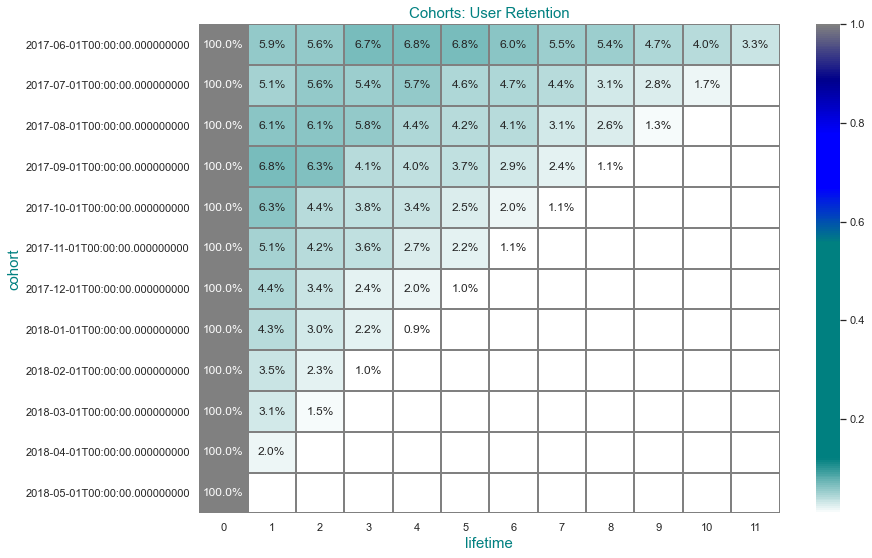

In [62]:
sns.set(style='white')
heat = plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention', fontdict={'size':15, 'color':'teal'})
plt.xlabel('Lifetime', fontdict={'size':15, 'color':'teal'})
plt.ylabel('First session', fontdict={'size':15, 'color':'teal'})
cmap = mcolors.LinearSegmentedColormap.from_list(
    name='test',
    colors=['white','teal','teal', 'teal', 'teal', 'teal', 'blue', 'blue', 'darkblue', 'grey'])
sns.heatmap(retention,annot=True, fmt='.1%', linewidths=1, linecolor='gray', cmap=cmap);

According to this heatmap, the retention rate of Yandex.Afisha users is not great. During the first month it reaches up to 6.8%, but later it keeps dropping.

The first cohort was fairly sucessful and managed to keep the retention rate at 3.3% even by the end of the year. But all the other cohorts dropped to 1-2% very quickly. The later the cohort started, the faster it dropped. For example, the second to last cohort (April 2018) showed 2% retention rate already in May.

The cohorts of September and October 2017 showed fairly good retention rate (6.3-6.8%) in October and November 2017. This fact is consistent with what we saw on the DAU dynamics graph: a significant peak on November 24, 2017.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Perfect 👏👏👏
</div>
</font>

### <a id='part2sales'>Sales</a>

In this section we will try to answer the following questions:

1. When do people start buying?
2. How many orders do they make during a given period of time?
3. What is the average purchase size?
4. What is the average lifetime value of a customer?

[Back to Contents](#cont)

<a id='part2conversion'>**Conversion time**</a>

In [63]:
first_order = orders.groupby('uid').agg({'buy_ts': 'min'}).reset_index()
first_order.columns = ['uid', 'first_order_date']
first_order

uid    first_order_date
0           313578113262317 2018-01-03 21:51:00
1          1575281904278712 2017-06-03 10:13:00
2          2429014661409475 2017-10-11 18:33:00
3          2464366381792757 2018-01-28 15:54:00
4          2551852515556206 2017-11-24 10:14:00
...                     ...                 ...
36504  18445147675727495770 2017-11-24 09:03:00
36505  18445407535914413204 2017-09-22 23:55:00
36506  18445601152732270159 2018-03-26 22:54:00
36507  18446156210226471712 2018-02-18 19:34:00
36508  18446167067214817906 2017-10-17 10:16:00

[36509 rows x 2 columns]

In [64]:
first_visit = logs[['uid', 'first_session']]
first_visit = first_visit.groupby('uid').agg({'first_session':'min'}).reset_index()
first_visit

uid first_session
0             11863502262781    2018-03-01
1             49537067089222    2018-02-06
2            297729379853735    2017-06-07
3            313578113262317    2017-09-18
4            325320750514679    2017-09-30
...                      ...           ...
228164  18446403737806311543    2017-11-30
228165  18446424184725333426    2017-12-06
228166  18446556406699109058    2018-01-01
228167  18446621818809592527    2017-12-27
228168  18446676030785672386    2017-10-04

[228169 rows x 2 columns]

In [65]:
first_order = first_order.merge(first_visit, on = 'uid', how='left')
first_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36509 entries, 0 to 36508
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               36509 non-null  uint64        
 1   first_order_date  36509 non-null  datetime64[ns]
 2   first_session     36509 non-null  object        
dtypes: datetime64[ns](1), object(1), uint64(1)
memory usage: 1.1+ MB


In [66]:
first_order['first_session'] = pd.to_datetime(first_order['first_session'])
first_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36509 entries, 0 to 36508
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               36509 non-null  uint64        
 1   first_order_date  36509 non-null  datetime64[ns]
 2   first_session     36509 non-null  datetime64[ns]
dtypes: datetime64[ns](2), uint64(1)
memory usage: 1.1 MB


In [67]:
first_order.query('first_order_date < first_session')

Empty DataFrame
Columns: [uid, first_order_date, first_session]
Index: []

In [68]:
first_order.isnull().sum()

uid                 0
first_order_date    0
first_session       0
dtype: int64

In [69]:
first_order['waiting_time'] = (first_order['first_order_date'] - first_order['first_session']).dt.days
first_order.head()

uid    first_order_date first_session  waiting_time
0   313578113262317 2018-01-03 21:51:00    2017-09-18           107
1  1575281904278712 2017-06-03 10:13:00    2017-06-03             0
2  2429014661409475 2017-10-11 18:33:00    2017-10-11             0
3  2464366381792757 2018-01-28 15:54:00    2018-01-27             1
4  2551852515556206 2017-11-24 10:14:00    2017-11-24             0

In [70]:
first_order['waiting_time'].describe()

count    36509.000000
mean        16.910159
std         47.093476
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        363.000000
Name: waiting_time, dtype: float64

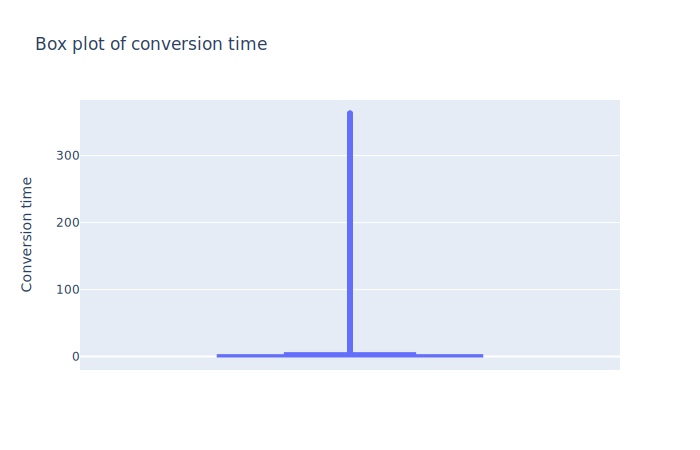

In [71]:
fig_wait = px.box(first_order, y='waiting_time', title = 'Box plot of conversion time',
                 labels=dict(waiting_time='Conversion time'))
fig_wait.show('svg')

Half of the orders are made during the day of the first session (both Q1 and Q2 are 0). Q3 is two days. However, there is a significant number of abnormally long conversion times, such as 363 days (almost a year). It is very hard to say whether this is an outlier or a legitimate data, so we will leave this dataset as is.

In [72]:
def conversion_category(row):
    time = row['waiting_time']
    if time == 0:
        return 'Cat. 1 (0 days)'
    elif 0 < time <= 7:
        return 'Cat. 2 (1-7 days)'
    elif 7 < time <= 14:
        return 'Cat. 3 (7-14 days)'
    elif 14 < time <= 30:
        return 'Cat. 4 (14-30 days)'
    else:
        return 'Cat. 5 (30 days and more)'

first_order['conversion_category'] = first_order.apply(conversion_category, axis=1)
first_order

uid    first_order_date first_session  waiting_time  \
0           313578113262317 2018-01-03 21:51:00    2017-09-18           107   
1          1575281904278712 2017-06-03 10:13:00    2017-06-03             0   
2          2429014661409475 2017-10-11 18:33:00    2017-10-11             0   
3          2464366381792757 2018-01-28 15:54:00    2018-01-27             1   
4          2551852515556206 2017-11-24 10:14:00    2017-11-24             0   
...                     ...                 ...           ...           ...   
36504  18445147675727495770 2017-11-24 09:03:00    2017-08-20            96   
36505  18445407535914413204 2017-09-22 23:55:00    2017-09-22             0   
36506  18445601152732270159 2018-03-26 22:54:00    2017-08-07           231   
36507  18446156210226471712 2018-02-18 19:34:00    2017-11-07           103   
36508  18446167067214817906 2017-10-17 10:16:00    2017-10-17             0   

             conversion_category  
0      Cat. 5 (30 days and more)  
1                Cat. 1 (0 days)  
2                Cat. 1 (0 days)  
3              Cat. 2 (1-7 days)  
4                Cat. 1 (0 days)  
...                          ...  
36504  Cat. 5 (30 days and more)  
36505            Cat. 1 (0 days)  
36506  Cat. 5 (30 days and more)  
36507  Cat. 5 (30 days and more)  
36508            Cat. 1 (0 days)  

[36509 rows x 5 columns]

In [73]:
first_order['conversion_category'].value_counts()

Cat. 1 (0 days)              25025
Cat. 5 (30 days and more)     4935
Cat. 2 (1-7 days)             4297
Cat. 4 (14-30 days)           1277
Cat. 3 (7-14 days)             975
Name: conversion_category, dtype: int64

In [74]:
conversion = first_order.groupby('conversion_category').agg({'uid':'nunique'}).reset_index()
conversion.columns = ['conversion_category', 'n_customers']
conversion.sort_values('conversion_category')

conversion_category  n_customers
0            Cat. 1 (0 days)        25025
1          Cat. 2 (1-7 days)         4297
2         Cat. 3 (7-14 days)          975
3        Cat. 4 (14-30 days)         1277
4  Cat. 5 (30 days and more)         4935

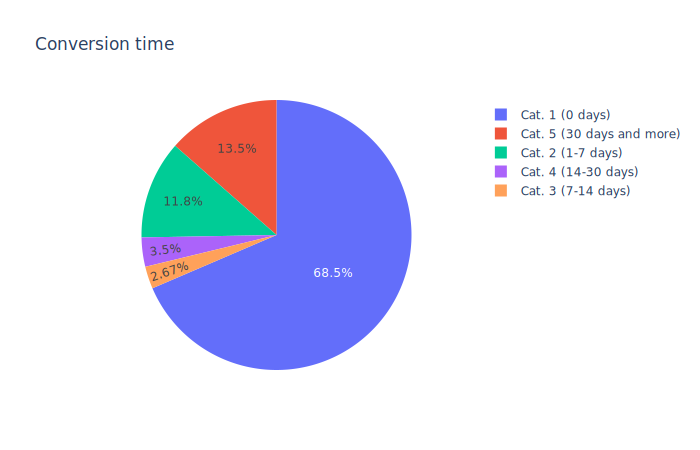

In [75]:
fig_conversion = px.pie(conversion, values='n_customers', names='conversion_category',
                        title='Conversion time',
                       labels=dict(conversion_category='Category', n_customers='Number of customers'))
fig_conversion.show('svg')

According to this pie chart, most users (68.5%) have converted within their 0s day. However, the secong biggest category is more than a month (13.5% users). A smaller number of users (11.8%) purchase something within a week from the first visit. 

[Back to Contents](#cont)

<font color='orange'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Well done block.
</div>
<div class="alert alert-block alert-warning">
The period of observation is much longer than a month. Next time I would suggest to make a monthly cohorts conversion rate report to investigate whole period of time.
</div>
</font>

<a id='part2orders'>**Number of orders**</a>

In [76]:
logs_slice = logs[['source_id', 'uid', 'cohort']]
logs_slice = logs_slice.groupby('uid').agg({'source_id':'first', 'cohort':'first'}).reset_index()
logs_slice.head()

uid  source_id     cohort
0   11863502262781          3 2018-03-01
1   49537067089222          2 2018-02-01
2  297729379853735          3 2017-06-01
3  313578113262317          2 2017-09-01
4  325320750514679          5 2017-09-01

In [77]:
orders_cohort = orders.merge(logs_slice, on='uid', how='inner')
orders_cohort.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50364 entries, 0 to 50363
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   buy_ts     50364 non-null  datetime64[ns]
 1   revenue    50364 non-null  float64       
 2   uid        50364 non-null  uint64        
 3   source_id  50364 non-null  int64         
 4   cohort     50364 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), uint64(1)
memory usage: 2.3 MB


In [78]:
orders_cohort['date'] = orders_cohort['buy_ts'].dt.date
orders_cohort['month'] = orders_cohort['buy_ts'].astype('datetime64[M]')
orders_cohort

buy_ts  revenue                   uid  source_id  \
0     2017-06-01 00:10:00    17.00  10329302124590727494          1   
1     2017-06-01 00:25:00     0.55  11627257723692907447          2   
2     2017-06-01 00:27:00     0.37  17903680561304213844          2   
3     2017-06-01 00:29:00     0.55  16109239769442553005          2   
4     2017-06-01 07:58:00     0.37  14200605875248379450          3   
...                   ...      ...                   ...        ...   
50359 2018-05-31 23:50:00     4.64  12296626599487328624          4   
50360 2018-05-31 23:50:00     5.80  11369640365507475976         10   
50361 2018-05-31 23:54:00     0.30   1786462140797698849          3   
50362 2018-05-31 23:56:00     3.67   3993697860786194247          4   
50363 2018-06-01 00:02:00     3.42     83872787173869366          4   

          cohort        date      month  
0     2017-06-01  2017-06-01 2017-06-01  
1     2017-06-01  2017-06-01 2017-06-01  
2     2017-06-01  2017-06-01 2017-06-01  
3     2017-06-01  2017-06-01 2017-06-01  
4     2017-06-01  2017-06-01 2017-06-01  
...          ...         ...        ...  
50359 2018-05-01  2018-05-31 2018-05-01  
50360 2018-05-01  2018-05-31 2018-05-01  
50361 2018-05-01  2018-05-31 2018-05-01  
50362 2017-10-01  2018-05-31 2018-05-01  
50363 2018-05-01  2018-06-01 2018-06-01  

[50364 rows x 7 columns]

In [79]:
orders_daily = orders_cohort.groupby('date').agg({'buy_ts':'nunique'}).reset_index()
orders_daily.columns = ['date', 'n_orders']
orders_daily.head()

date  n_orders
0  2017-06-01        90
1  2017-06-02       107
2  2017-06-03        65
3  2017-06-04        63
4  2017-06-05       152

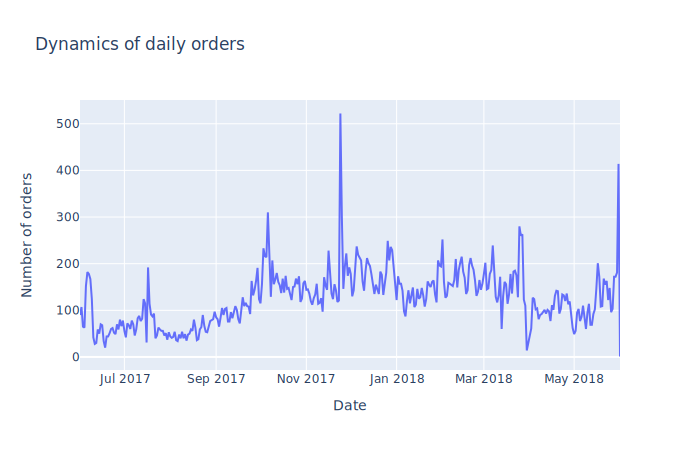

In [80]:
fig_daily = px.line(orders_daily, x='date', y='n_orders',
                    title='Dynamics of daily orders',
                   labels=dict(date='Date', n_orders='Number of orders'))
fig_daily.show('svg')

This line graph has several clear peaks, one of them on our favorite date: November 24, 2017, Black Friday. The other peaks are on October 6 (2017), March 25 and May 31 (both 2018). It's worth checking what happened on these days that increased the sales, though the answer could be found both in internal (performance of the website) and external factors (e.g. the first day of selling tickets to some extremely popular concert).

In [81]:
orders_monthly = orders_cohort.groupby(['month', 'source_id']).agg({'buy_ts':'nunique'}).reset_index()
orders_monthly.columns = ['month', 'source_id', 'n_orders']
orders_monthly.head()

month  source_id  n_orders
0 2017-06-01          1       265
1 2017-06-01          2       344
2 2017-06-01          3       611
3 2017-06-01          4       465
4 2017-06-01          5       427

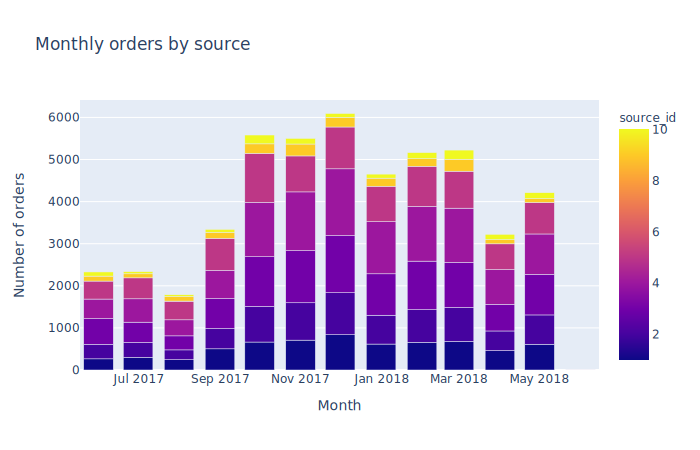

In [82]:
fig_month = px.bar(orders_monthly, x='month', y='n_orders', color='source_id',
                   title='Monthly orders by source',
                  labels=dict(month='Month', n_orders='Number of orders'))
fig_month.show('svg')

We've calculated the number of monthly orders and split the result by the ad source. As we've mentioned while preprocessing data, we've got statistics on marketing expenses for the sources 1-5, 9 and 10; however, users are also coming from the sources 6 and 7.

Now that we see the amount of orders they place, we can have a new look on this issue. While there is a visible growth in the number of orders since September 2017, advertising sources that most often lead to orders are 3 and 4, for some months also 5. Sources 1 and 2 provide humble, but steady share of orders. In this graph, sources 9 and 10 have the smallest shares.

As for the misterious sources 6 and 7, we don't see them on this graph at all.

In [83]:
sources_6_7 = len(logs.query('source_id == 6' and 'source_id == 7'))
purchases_6_7 = len(orders_cohort.query('source_id == 6' and 'source_id == 7'))
print('Number of people who came from ad sources 6 and 7: {}.'.format(sources_6_7))
print('Number of purchases they made: {}.'.format(purchases_6_7))

Number of people who came from ad sources 6 and 7: 36.
Number of purchases they made: 1.


This explains lack of attention of the marketing department to these sources.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Good job. Agree that sources 6 and 7 look mysterious ones.
</div>
</font>

<a id='part2avgsize'>**Average purchase size**</a>

In [84]:
avg_purchase = orders_cohort.groupby('cohort').agg({'revenue':'mean'}).reset_index()
avg_purchase['revenue'] = avg_purchase['revenue'].round(decimals=2)
avg_purchase.head()

cohort  revenue
0 2017-06-01     6.27
1 2017-07-01     5.03
2 2017-08-01     5.13
3 2017-09-01     7.75
4 2017-10-01     4.47

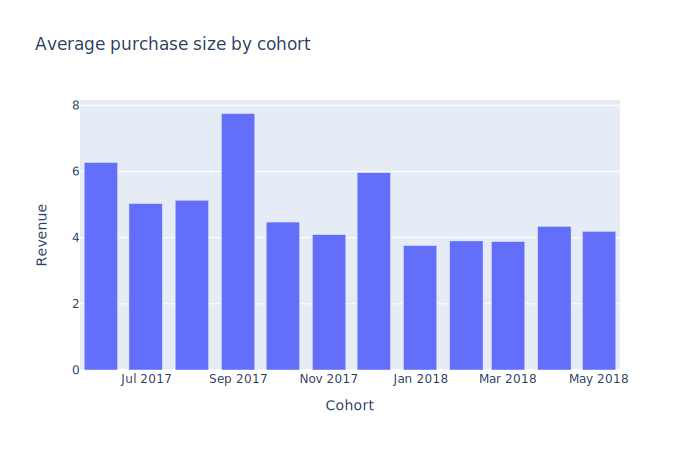

In [85]:
fig_avg = px.bar(avg_purchase, x='cohort', y='revenue',
                 title='Average purchase size by cohort',
                labels=dict(cohort='Cohort', revenue='Revenue'))
fig_avg.show('svg')

Judging by the average purchase size, the leading cohort is from September 2017. We also remember that it performed well from the heatmap. The other sucessful cohorts are June 2017 and December 2017. In general, the average revenue of an order decreased by the end of the observation period.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
I think it is due to seasonality. Cold time of the year looks more suitable to visit entertainment events.
</div>
</font>

<a id='part2ltv'>**Customers' lifetime value**</a>

In [86]:
orders_cohort.head()

buy_ts  revenue                   uid  source_id     cohort  \
0 2017-06-01 00:10:00    17.00  10329302124590727494          1 2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447          2 2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844          2 2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005          2 2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450          3 2017-06-01   

         date      month  
0  2017-06-01 2017-06-01  
1  2017-06-01 2017-06-01  
2  2017-06-01 2017-06-01  
3  2017-06-01 2017-06-01  
4  2017-06-01 2017-06-01

In [87]:
ltv = orders_cohort.groupby('cohort').agg({'revenue': 'sum', 'uid':'nunique'}).reset_index()
ltv.columns = ['cohort', 'total_revenue', 'n_users']
ltv['ltv'] = (ltv['total_revenue'] / ltv['n_users']).round(decimals=2)
ltv

cohort  total_revenue  n_users    ltv
0  2017-06-01       40026.05     2922  13.70
1  2017-07-01       17812.11     2457   7.25
2  2017-08-01       13461.87     1721   7.82
3  2017-09-01       33682.56     3057  11.02
4  2017-10-01       27857.69     4678   5.96
5  2017-11-01       24426.72     4259   5.74
6  2017-12-01       31157.85     4070   7.66
7  2018-01-01       14546.82     3119   4.66
8  2018-02-01       15061.29     3186   4.73
9  2018-03-01       13770.16     2838   4.85
10 2018-04-01        9882.55     1888   5.23
11 2018-05-01       10371.53     2314   4.48

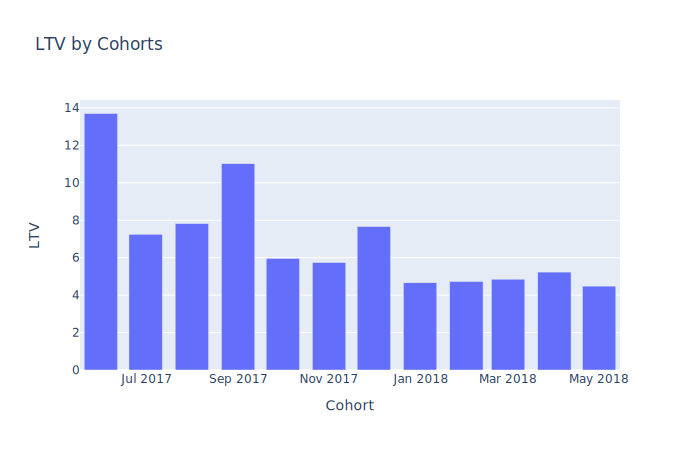

In [88]:
fig_ltv = px.bar(ltv, x='cohort', y='ltv',
                 title='LTV by Cohorts',
                labels=dict(cohort='Cohort', ltv='LTV'))
fig_ltv.show('svg')

Judging by the lifetime value (LTV) of the customers, the most sucessful cohorts are the first one (June 2017), September 2017, August 2017 and December 2017. In general, LTV of the customers decreased with each cohort.

In [89]:
ltv_source = orders_cohort.groupby('source_id').agg({'revenue': 'sum', 'uid':'nunique'}).reset_index()
ltv_source.columns = ['source_id', 'total_revenue', 'n_users']
ltv_source['ltv'] = (ltv['total_revenue'] / ltv['n_users']).round(decimals=2)
ltv_source

source_id  total_revenue  n_users    ltv
0          1       38560.06     3740  13.70
1          2       65152.26     4320   7.25
2          3       44317.68     9134   7.82
3          4       52479.75     9822  11.02
4          5       40357.91     6838   5.96
5          7           1.22        1   5.74
6          9        7076.98     1415   7.66
7         10        4111.34     1239   4.66

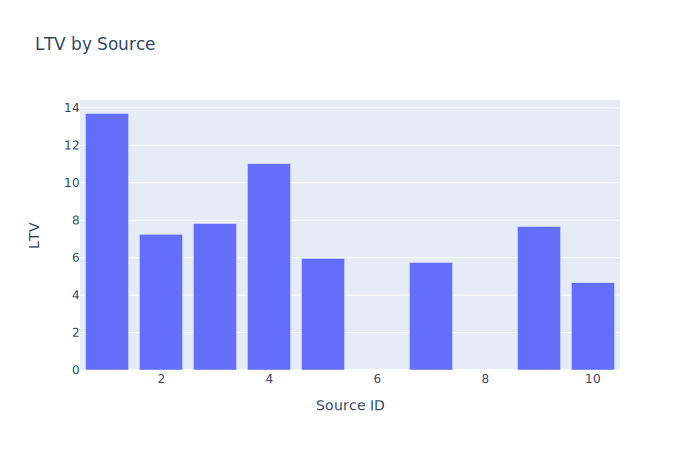

In [90]:
fig_ltv_source = px.bar(ltv_source, x='source_id', y='ltv',
                        title='LTV by Source',
                       labels=dict(ltv='LTV', source_id='Source ID'))
fig_ltv_source.show('svg')

If we compare LTV of the customers according to the ad source, we'll see that the most profitable sources are 1 and 4 (with LTV 13.7 and 11.02 respectively). Satisfactory results are also shown by sources 2, 3 and 9 (7.25, 7.82 and 7.66).

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Ok, agree, well done.
</div>
</font>

### <a id='part2marketing'>Markerting Expenses</a>

In this section, we are going to answer the following questions:

1. How much money was spent on advertising? Overall/per source/over time
2. How much did customer acquisition from each of the sources cost?
3. How worthwhile where the investments (ROI)?

[Back to Contents](#cont)

<a id='part2advcost'>**Cost of advertising**</a>

In [91]:
costs.head()

source_id advertising_ts  advertising_costs
0          1     2017-06-01              75.20
1          1     2017-06-02              62.25
2          1     2017-06-03              36.53
3          1     2017-06-04              55.00
4          1     2017-06-05              57.08

In [92]:
total_costs = costs['advertising_costs'].sum()
print('Total marketing costs: {}.'.format(total_costs))

Total marketing costs: 329131.62.


In [93]:
costs_source = costs.groupby('source_id').agg({'advertising_costs':'sum'}).reset_index()
costs_source

source_id  advertising_costs
0          1           20833.27
1          2           42806.04
2          3          141321.63
3          4           61073.60
4          5           51757.10
5          9            5517.49
6         10            5822.49

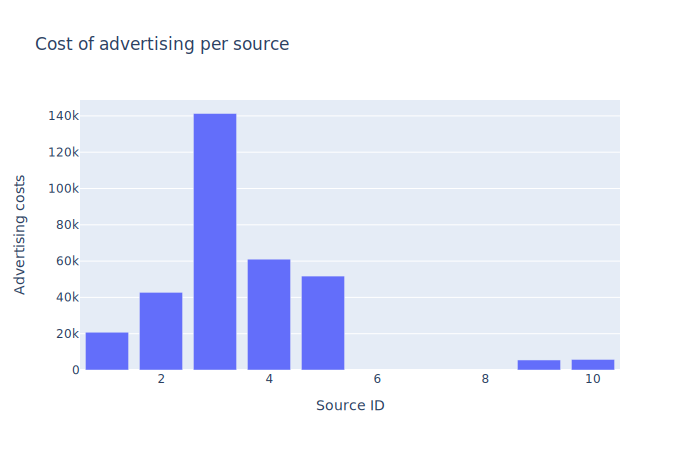

In [94]:
fig_costs_source = px.bar(costs_source, x='source_id', y='advertising_costs',
                          title = 'Cost of advertising per source',
                         labels=dict(source_id='Source ID', advertising_costs='Advertising costs'))
fig_costs_source.show('svg')

Marketing expenses on the source #3 really stand out. During the year they reached 141,000, while expenses on other sources varied from 5,500 to 61,000.

In [95]:
costs['month'] = costs['advertising_ts'].astype('datetime64[M]')
costs.head()

source_id advertising_ts  advertising_costs      month
0          1     2017-06-01              75.20 2017-06-01
1          1     2017-06-02              62.25 2017-06-01
2          1     2017-06-03              36.53 2017-06-01
3          1     2017-06-04              55.00 2017-06-01
4          1     2017-06-05              57.08 2017-06-01

In [96]:
costs_month = costs.groupby('month').agg({'advertising_costs':'sum'}).reset_index()
costs_month.head()

month  advertising_costs
0 2017-06-01           18015.00
1 2017-07-01           18240.59
2 2017-08-01           14790.54
3 2017-09-01           24368.91
4 2017-10-01           36322.88

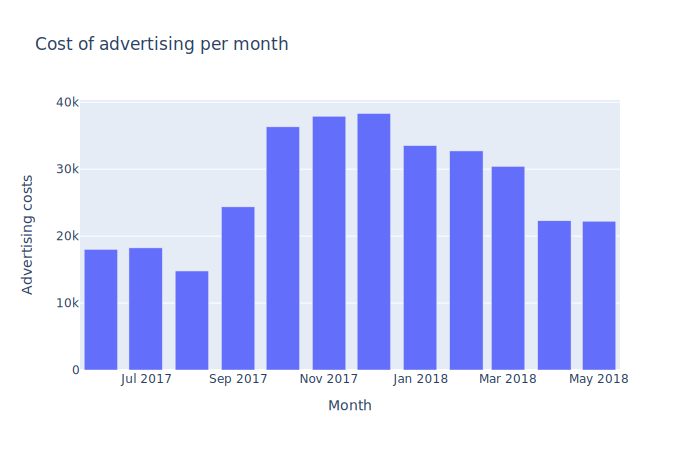

In [97]:
fig_costs_month = px.bar(costs_month, x='month', y='advertising_costs',
                         title = 'Cost of advertising per month',
                        labels=dict(month='Month', advertising_costs='Advertising costs'))
fig_costs_month.show('svg')

In general, marketing expenses rose over the course of the year. Most money was spent on advertising between October 2017 and March 2018.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Agree that the source 3 is the most expensive however as we could see in the block above it doesn bring the most value. There is a lot to think on for the marketing dept. Good valuable finding 👍👍👍
</div>
</font>

<a id='part2cac'>**Customer acqusition cost**</a>

In [98]:
cust_per_source = logs.groupby('source_id').agg({'uid':'nunique'}).reset_index()
cust_per_source.columns = ['source_id', 'n_customers']
cust_per_source

source_id  n_customers
0          1        18999
1          2        26245
2          3        74756
3          4        83525
4          5        56974
5          6            6
6          7           34
7          9         9264
8         10         8067

In [99]:
costs_source = costs_source.merge(cust_per_source, on='source_id', how='outer')
costs_source

source_id  advertising_costs  n_customers
0          1           20833.27        18999
1          2           42806.04        26245
2          3          141321.63        74756
3          4           61073.60        83525
4          5           51757.10        56974
5          9            5517.49         9264
6         10            5822.49         8067
7          6                NaN            6
8          7                NaN           34

In [100]:
costs_source['cac'] = costs_source['advertising_costs'] / costs_source['n_customers']
costs_source = costs_source.round(decimals=2).fillna(0)
costs_source

source_id  advertising_costs  n_customers   cac
0          1           20833.27        18999  1.10
1          2           42806.04        26245  1.63
2          3          141321.63        74756  1.89
3          4           61073.60        83525  0.73
4          5           51757.10        56974  0.91
5          9            5517.49         9264  0.60
6         10            5822.49         8067  0.72
7          6               0.00            6  0.00
8          7               0.00           34  0.00

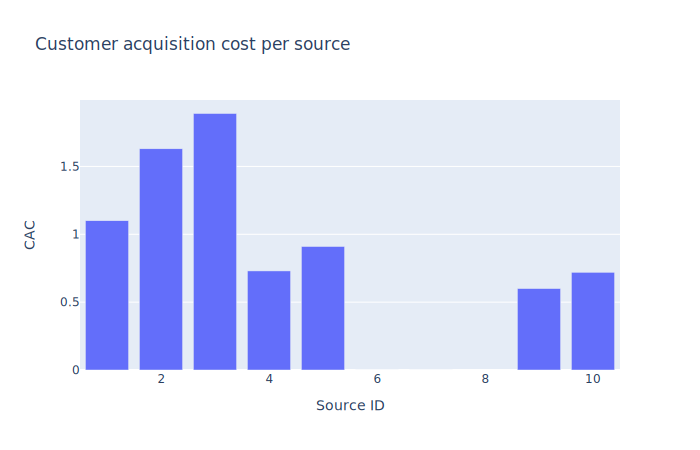

In [101]:
fig_cac = px.bar(costs_source, x='source_id', y='cac',
                 title='Customer acquisition cost per source',
                labels=dict(source_id='Source ID', cac='CAC'))
fig_cac.show('svg')

After calculating CAC (customer acquisition cost), we see that this parameter is highest for the sources 2 and 3 (1.63 and 1.89 respectively). In fact, it's almost twice more expensive than for all the other sources (varying from 0.6 to 1.1).

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Well done 👍👍👍
</div>
</font>

<a id='part2romi'>**Return on marketing investments**</a>

We are going to calculate the ROMI parameter (return on marketing investments) by dividing lifetime value of customers by their acquisition cost.

In [102]:
romi_source = ltv_source.merge(costs_source, on='source_id', how='outer')
romi_source

source_id  total_revenue  n_users    ltv  advertising_costs  n_customers  \
0          1       38560.06   3740.0  13.70           20833.27        18999   
1          2       65152.26   4320.0   7.25           42806.04        26245   
2          3       44317.68   9134.0   7.82          141321.63        74756   
3          4       52479.75   9822.0  11.02           61073.60        83525   
4          5       40357.91   6838.0   5.96           51757.10        56974   
5          7           1.22      1.0   5.74               0.00           34   
6          9        7076.98   1415.0   7.66            5517.49         9264   
7         10        4111.34   1239.0   4.66            5822.49         8067   
8          6            NaN      NaN    NaN               0.00            6   

    cac  
0  1.10  
1  1.63  
2  1.89  
3  0.73  
4  0.91  
5  0.00  
6  0.60  
7  0.72  
8  0.00

But before doing that we should subset the dataframe, since it has missing data. E.g. sources 6 and 7 have almost no revenue and no marketing expenses at all, so they won't be used in our calculations.

In [103]:
romi_source = romi_source[romi_source.notnull().all(axis=1)]
romi_source = romi_source.query('cac != 0').reset_index()
romi_source

index  source_id  total_revenue  n_users    ltv  advertising_costs  \
0      0          1       38560.06   3740.0  13.70           20833.27   
1      1          2       65152.26   4320.0   7.25           42806.04   
2      2          3       44317.68   9134.0   7.82          141321.63   
3      3          4       52479.75   9822.0  11.02           61073.60   
4      4          5       40357.91   6838.0   5.96           51757.10   
5      6          9        7076.98   1415.0   7.66            5517.49   
6      7         10        4111.34   1239.0   4.66            5822.49   

   n_customers   cac  
0        18999  1.10  
1        26245  1.63  
2        74756  1.89  
3        83525  0.73  
4        56974  0.91  
5         9264  0.60  
6         8067  0.72

In [104]:
romi_source['romi'] = (romi_source['ltv'] / romi_source['cac']).round(decimals=2)
romi_source

index  source_id  total_revenue  n_users    ltv  advertising_costs  \
0      0          1       38560.06   3740.0  13.70           20833.27   
1      1          2       65152.26   4320.0   7.25           42806.04   
2      2          3       44317.68   9134.0   7.82          141321.63   
3      3          4       52479.75   9822.0  11.02           61073.60   
4      4          5       40357.91   6838.0   5.96           51757.10   
5      6          9        7076.98   1415.0   7.66            5517.49   
6      7         10        4111.34   1239.0   4.66            5822.49   

   n_customers   cac   romi  
0        18999  1.10  12.45  
1        26245  1.63   4.45  
2        74756  1.89   4.14  
3        83525  0.73  15.10  
4        56974  0.91   6.55  
5         9264  0.60  12.77  
6         8067  0.72   6.47

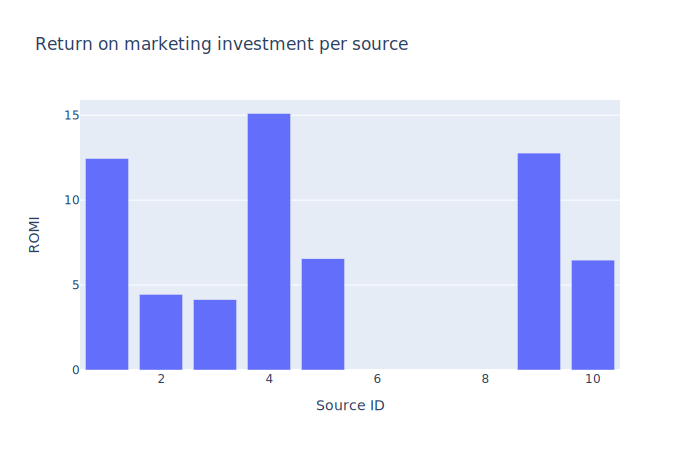

In [105]:
fig_romi = px.bar(romi_source, x='source_id', y='romi',
                 title='Return on marketing investment per source',
                 labels=dict(source_id='Source ID', romi='ROMI'))
fig_romi.show('svg')

After calculating ROMI we see that from this point of view the most prespective advertising sources by far are 1, 4 and 9. 

In [106]:
romi_cohort= ltv.merge(costs_month, left_on='cohort', right_on='month', how='outer')
romi_cohort

cohort  total_revenue  n_users    ltv      month  advertising_costs
0  2017-06-01       40026.05     2922  13.70 2017-06-01           18015.00
1  2017-07-01       17812.11     2457   7.25 2017-07-01           18240.59
2  2017-08-01       13461.87     1721   7.82 2017-08-01           14790.54
3  2017-09-01       33682.56     3057  11.02 2017-09-01           24368.91
4  2017-10-01       27857.69     4678   5.96 2017-10-01           36322.88
5  2017-11-01       24426.72     4259   5.74 2017-11-01           37907.88
6  2017-12-01       31157.85     4070   7.66 2017-12-01           38315.35
7  2018-01-01       14546.82     3119   4.66 2018-01-01           33518.52
8  2018-02-01       15061.29     3186   4.73 2018-02-01           32723.03
9  2018-03-01       13770.16     2838   4.85 2018-03-01           30415.27
10 2018-04-01        9882.55     1888   5.23 2018-04-01           22289.38
11 2018-05-01       10371.53     2314   4.48 2018-05-01           22224.27

In [107]:
romi_cohort['romi'] = (romi_cohort['total_revenue'] / romi_cohort['advertising_costs']).round(decimals=2)
romi_cohort

cohort  total_revenue  n_users    ltv      month  advertising_costs  \
0  2017-06-01       40026.05     2922  13.70 2017-06-01           18015.00   
1  2017-07-01       17812.11     2457   7.25 2017-07-01           18240.59   
2  2017-08-01       13461.87     1721   7.82 2017-08-01           14790.54   
3  2017-09-01       33682.56     3057  11.02 2017-09-01           24368.91   
4  2017-10-01       27857.69     4678   5.96 2017-10-01           36322.88   
5  2017-11-01       24426.72     4259   5.74 2017-11-01           37907.88   
6  2017-12-01       31157.85     4070   7.66 2017-12-01           38315.35   
7  2018-01-01       14546.82     3119   4.66 2018-01-01           33518.52   
8  2018-02-01       15061.29     3186   4.73 2018-02-01           32723.03   
9  2018-03-01       13770.16     2838   4.85 2018-03-01           30415.27   
10 2018-04-01        9882.55     1888   5.23 2018-04-01           22289.38   
11 2018-05-01       10371.53     2314   4.48 2018-05-01           22224.27   

    romi  
0   2.22  
1   0.98  
2   0.91  
3   1.38  
4   0.77  
5   0.64  
6   0.81  
7   0.43  
8   0.46  
9   0.45  
10  0.44  
11  0.47

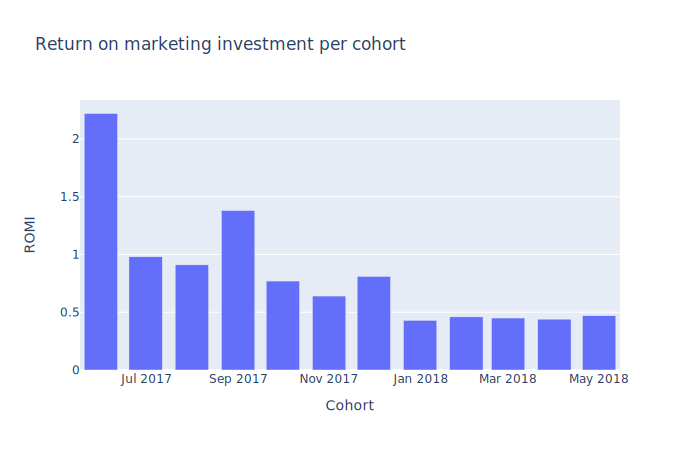

In [108]:
fig_romi_cohort = px.bar(romi_cohort, x='cohort', y='romi',
                        title='Return on marketing investment per cohort',
                        labels=dict(cohort='Cohort', romi='ROMI'))
fig_romi_cohort.show('svg')

After assessing ROMI by cohort, we can name several of the most sucessful cohorts: June 2017, September 2017 and Decemner 2017. This corresponds to the results we've seen on the heatmap and on the bar chart of the average purchase size.

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER COMMENT</u>
<br/>
<div class="alert alert-block alert-success">
Source 4 is the most profitable, great.
</div>
</font>

### <a id='part2concl'>*Conclusions to Part 2*</a>
In this part of our research we've calculated various business metrics, such as numbers of daily, weekly and monthly active users, average number of sessions per day and their length, retention rate, lifetime value of a customer (LTV), customer acqusition cost (CAC) and return on marketing investment (ROMI).

This gave us pretty consistent results which repeat from graph to graph and indicate some issues of the marketing strategy that require attention.

[Back to Contents](#cont)

## <a id='genconcl'>General Conclusions</a>

We've exprored the Yandex.Afisha data from two points of view: both in terms of cohorts and sources of advertising. This lead us to some final conclusions.

**1.** Unfortunately, the overall situation of Yandex.Afisha service is not perfect. True, due to expanding marketing budget the overall number of daily visitors and orders growth, but these customers don't stay for a long time. **Retention rate is dropping with each cohort** and reaching 1-2% very quickly. The second to last cohort (April 2018) dropped to this level during the first month of its lifetime.

Several cohorts can be considered more sucessful than the others. Among them the first cohort (June 2016) and the cohort of September and October 2017, but even they showed very small retention rate by their 8th and 7th months.

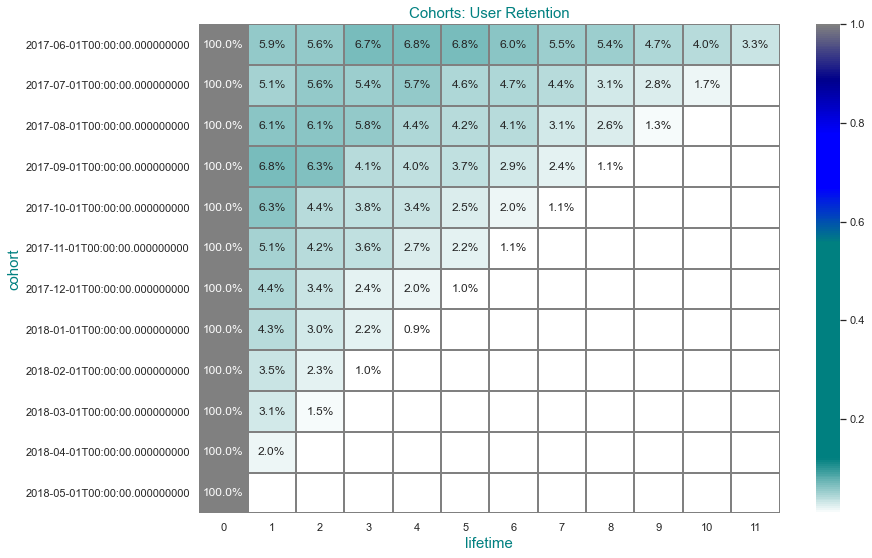

In [109]:
heat

These results are mirrored in revenue statistics. As depicted on the graphs below, leading cohorts by the average purchase size are June 2017 (6.27), September 2017 (7.75) and December 2017 (5.96). In general, we see a slight decrease of this parameter by the end of the observation period.

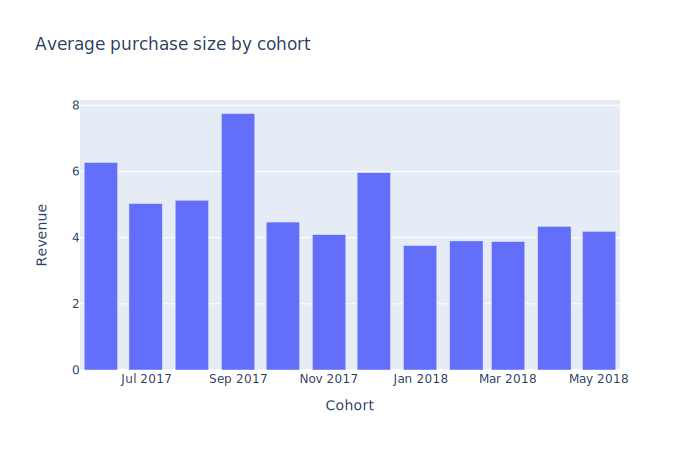

In [110]:
fig_avg.show('svg')

Lifetime value of the customers (LTV) demonstrates the same dynamics. The biggest lifetime revenue was brought in by the users from the following cohorts: June, September and December 2017. And exactly these three cohorts showed the biggest return on marketing investments.

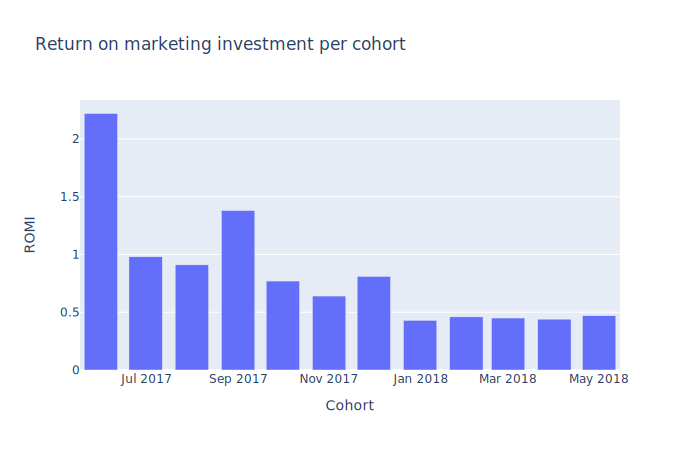

In [111]:
fig_romi_cohort.show('svg')

**2.** Before speaking about marketing expenses, we should notice that they were heavily centered on advertising source 3. For this source, they reached 141,000, while expenses on other sources varied between 5,500 and 61,000. However, did this decision pay off?

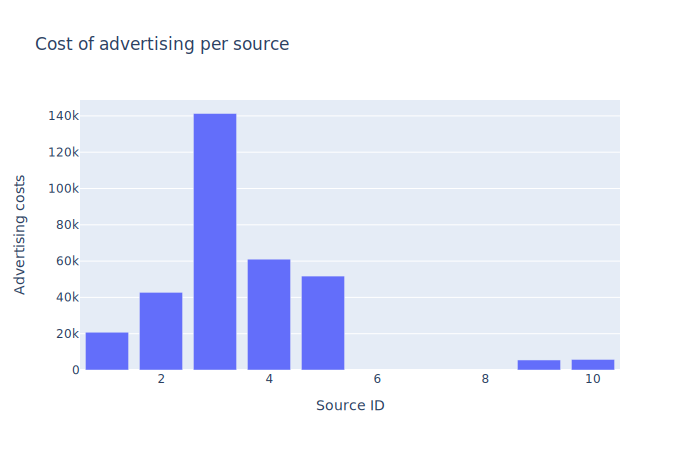

In [112]:
fig_costs_source.show('svg')

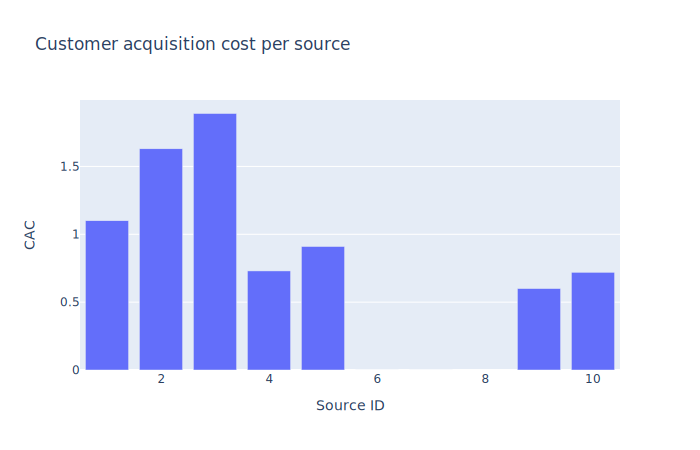

In [113]:
fig_cac.show('svg')

After we've calculated customer acquisition cost by source, we can see that this parameter is highest for the sources 2 and 3 (1.63 and 1.89 respectively). It means, that the marketing budget is arranged in a non-efficient way: its biggest part is spent on the source 3, which has the highest cost of attracting a customer. That could be optimised.

But what about the profit these expensive customers bring in? Theoretically this high CAC could be covered by customers' lifetime value.

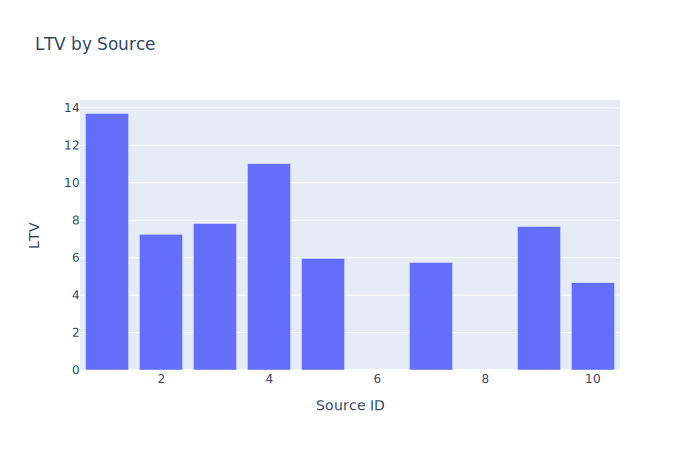

In [114]:
fig_ltv_source.show('svg')

However, it's not our case. In terms of custorems' LTV, the most profitable sources are 1 and 4 (with LTV 13.7 and 11.02 respectively).

To sum it all up, we suggest reviewing the marketing budget and potentially **cutting down expenses on the advertising source 3** in favour of some more profitable sources. E.g. **sources 1, 4 and 9 show much higher lifetime value** of users and **better return on marketing investments**. 

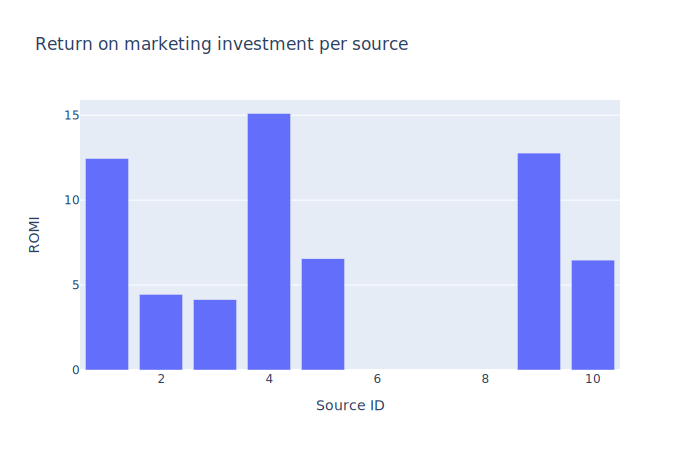

In [115]:
fig_romi.show('svg')

**3.** As we've assessed the dynamics of daily orders, we've got a graph with several noticeable peaks and one major downfall. The highest peak happened on **November 24, 2017** (Black Friday). We can see a corresponding peak on the graph of active daily users.

The other peaks are on October 6 (2017), March 26 and May 31 (both 2018). As we've mentioned earlier, this could happen both due to activities of the marketing department and external factors (e.g. the first day of selling tickets to some extremely popular concert). Still, **it's worth checking what happened on these dates that increased the sales**. It's equally important to try to establish the reason for a sudden drop in number of active users and orders on March 30-31, 2018.

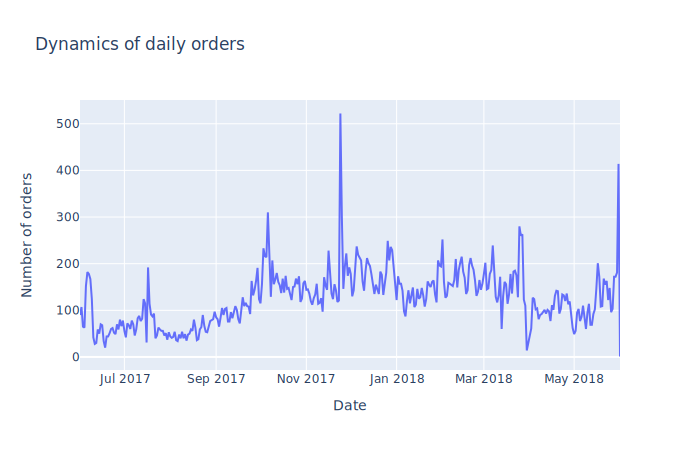

In [116]:
fig_daily.show('svg')

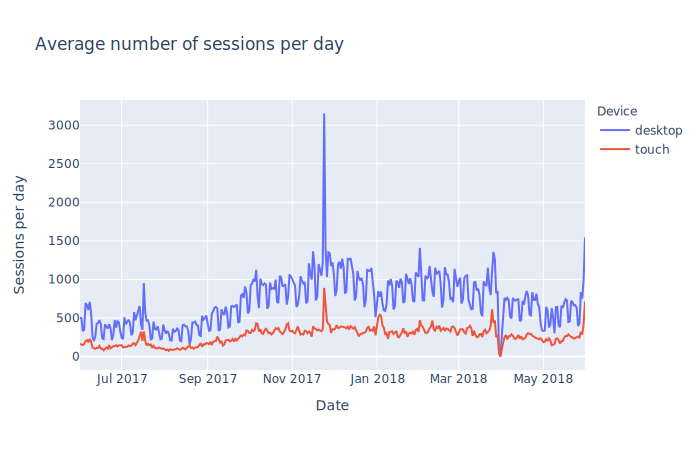

In [117]:
fig_device.show('svg')

**4.** And finally, we'd like to make a short description of Yandex.Afisha customers' behavior.

We've learned that the majority of them **prefer desktop computers to touchscreen devices**. This doesn't correlate so well with <a href='https://wearesocial-net.s3.amazonaws.com/uk/wp-content/uploads/sites/2/2017/01/Slide035.png'>the global internet usage trends for 2017</a>, so it's worth checking the mobile version of the website — perhaps, there is a way to make it **more user-friendly**? A median desktop session is also longer than touchscreen device session (5 minutes vs. 3 minutes).

The majority of users have only **one session per day**. But there is a number of people who visit Yandex.Afisha two or three times a day, or sometimes even more (up to ten).

For 68.5% of the users conversion (first purchase) happens **on the day of the first visit**, for 11.8% — within the first week. However, 13.5% of users convert only after 30 days or more.

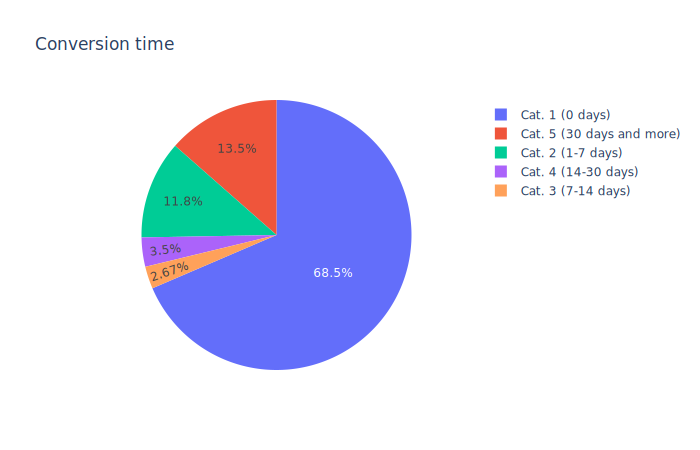

In [118]:
fig_conversion.show('svg')

[Back to Contents](#cont)

<font color='grenn'> 
### <u>REVIEWER SUMMARY</u>
<br/>
<div class="alert alert-block alert-success">
Great! 👏👏👏<br/>
It is the most difficult and laborious project on the course and it is just perfect. You demonstrated strong skills in data analysis. You are able to apply all tools you need: python coding, data processing, nice visualization, self commented print outs, detailed markdown comments, structured titles. Any customer would be happy to work with you.<br/>
I am glad to accept the project and wish you new achievemenets in next learning and career. Good luck! 👋👋👋
</div>
</font>